# Instructions for Project 1 - Sentiment Classification

Hello everyone, this is Zihao. I am very happy to host the first project

In this project, you will conduct a sentiment analysis task.
You will build a model to predict the scores (a.k.a. stars, from 1-5) of each review.
For each review, you are given a piece of text as well as some other features (Explore yourself!).
You can consider the predicted variables to be categorical, ordinal or numerical.

DDL: *April 6, 2021*
- *March 23, 2021* release the validation score of weak baseline
- *March 30, 2021* release the validation score of strong baseline

Submission: Each team leader is required to submit the groupNo.zip file in the canvas. It shoud contain 
- `pre.csv` Predictions on test data (please make sure you can successfully evaluate your validation predictions on the validation data with the help of evaluate.py)
- report (1-2 pages of pdf)
- code (Frameworks and programming languages are not restricted.)

We will check your report with your code and the accuracy.

| Grade | Classifier (80%)                                                   | Report (20%)                      |
|-------|--------------------------------------------------------------------|-----------------------------------|
| 50%   | example code in tutorials or in Project 1 without any modification | submission                        |
| 60%   | an easy baseline that most students can outperform                 | algorithm you used                |
| 80%   | a competitive baseline that about half students can surpass        | detailed explanation              |
| 90%   | a very competitive baseline without any special mechanism          | detailed explanation and analysis, such as explorative data analysis and ablation study |
| 100%  | a very competitive baseline with at least one mechanism            | excellent ideas, detailed explanation and solid analysis |



In this notebook, you are provided with the code snippets for you to start.

The content follows previous lectures and tutorials. But I may mention some useful python packages.

## Instruction Content

1. Load & Dump the data
    1. Load the data
    1. Dump the data
1. Preprocessing
    1. Text data processing recap
    1. Explorative data analysis
1. Learning Baselines

## 1. Load & Dump the data

The same as previous tutorials, we use `pandas` as the basic tool to load & dump the data.
The key ingredient of our operation is the `DataFrame` in pandas.

In [1]:
import pandas as pd

### A. Load the data

Here is a function to load your data, remember put the dataset in the `data_2021_spring` folder.

Each year we release different data, so old models are not guaranteed to solve the new data.

In [2]:
def load_data(split_name='train', columns=['text', 'stars']):
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        df = df.loc[:,columns]
        print("succeed!")
        return df
    except:
        print("Failed, then try to ")
        print(f"select all columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        return df

Then you can extract the data by specifying the desired split and columns

In [3]:
train_df = load_data('train', columns=['text','stars'])

select [text, stars] columns from the train split
succeed!


In [4]:
train_df.head()

,text,stars
0,Nice to have a diner still around. Food was go...,4
1,"Tried this a while back, got the fried chicken...",2
2,I expected more pork selections on menu. Food ...,4
3,YUMMY!!! This place is phenomenal. It is Price...,4
4,The Truffle Macaroni & Cheese and Potatoes Au ...,5


In [5]:
test_df = load_data('test')

select [text, stars] columns from the test split
Failed, then try to 
select all columns from the test split


In [6]:
len(test_df)

2000

### B. Dump the random answer

In this project, your predictions on test data are supposed to be submitted by a csv file of two columns, i.e. (review_id and stars)

Here we compose the random answer in a DataFrame and dump the answer into a csv file

In [7]:
import numpy as np

In [8]:
random_ans = pd.DataFrame(data={
    'review_id': test_df['review_id'],
    'stars': np.random.randint(0, 6, size=len(test_df))
})

In [9]:
random_ans.head()

,review_id,stars
0,b8-ELBwhmDKcmcM8icT86g,1
1,rBpAJhIen_V-zLoXZIcROg,2
2,_pALaDG6se9OTkGGhyhnNA,5
3,ru8fpA1Uk0tTFtO5hLM49g,2
4,fRPgwuFoY6SriToXZyaOQA,1


In [10]:
group_number = -1
random_ans.to_csv(f'{group_number}-random_ans.csv', index=False)

## 2. Preprocessing

Preprocessing and feature engineering is important in machine learning

### A. Text data processing recap
In our tutorials, Haoran have showed you how to extract textual features by the `nltk` package

Remember to use the NLTK Downloader to obtain the resource:
```
  >>> import nltk
  >>> nltk.download('stopwords')
  >>> nltk.download('punkt')
```

In [11]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
ps = PorterStemmer()

def lower(s):
    """
    :param s: a string.
    return a string with lower characters
    Note that we allow the input to be nested string of a list.
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: 'text mining is to identify useful information.'
    """
    if isinstance(s, list):
        return [lower(t) for t in s]
    if isinstance(s, str):
        return s.lower()
    else:
        raise NotImplementedError("unknown datatype")


def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)


def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

def n_gram(tokens, n= 3):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results

def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

def get_onehot_vector(feats, feats_dict):
    """
    :param data: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector


def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = [f for f, cnt in feat_cnt.most_common(max_size)]
    else:
        valid_feats = list()
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]        
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

In [12]:
def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        f_idx = feats_dict.get(f, 1)
        vector[i] = f_idx
    return vector

Note that you can use the `map` function to apply your preprocessing functions into the dataframe.

In [13]:
test_df['tokens'] = test_df['text'].map(tokenize).map(filter_stopwords).map(lower)
print(test_df['tokens'].head().to_string())

0    [i, took, up, train, union, station, catch, ai...
1    [we, worked, fitness, twist, part, best, frien...
2    [it, 's, typical, ,, average, ,, run-of-the-mi...
3    [we, went, outback, today, celebrate, daughter...
4    [we, went, see, nashville, unplugged, country,...


Besides `nltk`, I would like to introduce `SpaCy`, a newer text processing toolkit of industrial strength.

You can explore it at https://spacy.io/

Let's install it

```bash
python -m pip install spacy
python -m spacy download en_core_web_sm
```

In [14]:
import spacy
nlp = spacy.load('en_core_web_sm')

SpaCy enables you use linguistic features of texts

Example:

In [15]:
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

fmt = "{:10s},\t " * 8
print(fmt.format('raw', 'stem', 'PartOfSpeech', 'dependency', 'shape', 'is alpha', 'is stop', 'its childrens in the parsing tree'))
print('-'*140)
for token in doc:
    print(fmt.format(token.text, token.lemma_, token.pos_, token.dep_,
            token.shape_, str(token.is_alpha), str(token.is_stop), str(list(token.children))))

raw       ,	 stem      ,	 PartOfSpeech,	 dependency,	 shape     ,	 is alpha  ,	 is stop   ,	 its childrens in the parsing tree,	 
--------------------------------------------------------------------------------------------------------------------------------------------
Apple     ,	 Apple     ,	 PROPN     ,	 nsubj     ,	 Xxxxx     ,	 True      ,	 False     ,	 []        ,	 
is        ,	 be        ,	 AUX       ,	 aux       ,	 xx        ,	 True      ,	 True      ,	 []        ,	 
looking   ,	 look      ,	 VERB      ,	 ROOT      ,	 xxxx      ,	 True      ,	 False     ,	 [Apple, is, at, startup],	 
at        ,	 at        ,	 ADP       ,	 prep      ,	 xx        ,	 True      ,	 True      ,	 [buying]  ,	 
buying    ,	 buy       ,	 VERB      ,	 pcomp     ,	 xxxx      ,	 True      ,	 False     ,	 [U.K.]    ,	 
U.K.      ,	 U.K.      ,	 PROPN     ,	 dobj      ,	 X.X.      ,	 False     ,	 False     ,	 []        ,	 
startup   ,	 startup   ,	 NOUN      ,	 advcl     ,	 xxxx      ,	 True      ,	 False  

SpaCy also allows you use the embeddings for both sentence and words

Example:

In [16]:
print(doc, doc.vector[:5], '...')
for t in doc:
    print(t, t.vector[:5], '...')

Apple is looking at buying U.K. startup for $1 billion [ 0.4847193   0.34561655  0.23650904 -0.27294627  0.30828613] ...
Apple [ 0.9396687   0.46727175 -0.3862503  -0.23296848  0.25683203] ...
is [-0.21470308 -0.36800703  1.8618155  -0.43874717 -0.6448474 ] ...
looking [ 1.5960355  -0.01218066 -0.1948367   0.7979922   0.36900565] ...
at [-1.2617028  -0.8116296  -0.55736023  0.08604071 -0.43663728] ...
buying [ 0.3020423  -0.9611639   1.2695026   0.10633498  2.8583994 ] ...
U.K. [ 2.2959712   0.78135234 -1.0174923  -0.5566485   0.69199914] ...
startup [0.6782811  0.03798376 0.07798427 0.1210558  0.5636424 ] ...
for [-0.07904667 -0.21996386 -1.3529027  -0.24131706  0.43687835] ...
$ [ 0.44878927  0.75564337  0.5757578  -1.1713823   0.7438692 ] ...
1 [-0.3846085  2.7049747  2.7081459 -1.4393395 -0.5412608] ...
billion [ 1.011186    1.4275012  -0.38276425 -0.03342953 -0.9067332 ] ...


For more usage of SpaCy, you can refer to the documentation of spacy https://spacy.io/usage

### B. Explorative data analysis

For our dataset, we have features more than text

In [17]:
train_df_full = load_data('train', columns='full')

select [f, u, l, l] columns from the train split
Failed, then try to 
select all columns from the train split


In [18]:
train_df_full.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,39rLHYJOy2774ZIUouuWLw,0,2017-06-28 21:44:02,0,ynzOFepQYSCDGdfWDWxiZw,4,Nice to have a diner still around. Food was go...,0,Sl6VgFOB-XXfFIAYp7TFkw
1,E-Kq1Yu1d6N3TL2qX0aqjA,0,2018-04-09 03:45:19,0,sQX9ncJBEdBf16AWsvO6Vg,2,"Tried this a while back, got the fried chicken...",0,gcx01pMqWzkni2UC-zoZrA
2,nWW6fBfBljiRFa4sG7TyxA,0,2014-07-19 02:00:04,0,bVIf2kqbzvif3miNe3ARNw,4,I expected more pork selections on menu. Food ...,0,Mn9VzPbrCYU4EcP_C1oBOg
3,qmIHO-6T_KEfPC9jyGDamQ,0,2011-11-11 08:10:24,0,LNj1OFxy2ool3PZANGchPA,4,YUMMY!!! This place is phenomenal. It is Price...,0,SKV1heo00fdciCbCN9Z33A
4,pKk7jCFIm96qDdk0laVT2w,1,2010-01-16 20:04:00,1,bZXxa0hO6wQlHD-MkMf4iw,5,The Truffle Macaroni & Cheese and Potatoes Au ...,1,p1r7rZYruZR92x1A649PTQ


In [19]:
val_df_full = load_data('valid', columns='full')

select [f, u, l, l] columns from the valid split
Failed, then try to 
select all columns from the valid split


In [20]:
test_df_full = load_data('test', columns='full')

select [f, u, l, l] columns from the test split
Failed, then try to 
select all columns from the test split


In [21]:
test_df_full.head()

,business_id,cool,date,funny,review_id,text,useful,user_id
0,7YYrZ9LgjpKLTtF-huhJug,0,2018-04-04 21:21:45,0,b8-ELBwhmDKcmcM8icT86g,I took the UP Train to Union Station to catch ...,0,9Lglv-v8SRo_S-IyvFBmbw
1,gyNixTgp1yFX97soBZpZ7Q,1,2013-07-10 00:04:01,0,rBpAJhIen_V-zLoXZIcROg,We worked with Fitness with a Twist for part o...,1,zIl62G84XT2BwSIAjjjvYw
2,vNWfQrQCa_XijstJbylcDQ,1,2015-10-28 01:23:21,2,_pALaDG6se9OTkGGhyhnNA,"It's your typical, average, run-of-the-mill co...",1,WP7FsUsgNW24s7HH5xi7pg
3,wfxmuA7LbKZKVLV58EiWBw,0,2015-11-19 03:48:40,0,ru8fpA1Uk0tTFtO5hLM49g,We went to Outback today to celebrate my daugh...,0,yLSj54f2YgGQu-lhPIhMTQ
4,5jTmjxb1X34EfcY1gos4tw,0,2016-06-04 23:29:46,0,fRPgwuFoY6SriToXZyaOQA,We Went to see Nashville unplugged a country c...,1,73-u0a3G9Le4GWG7zLYWtg


You can explore the relationship between different features

In [22]:
import matplotlib.pyplot as plt

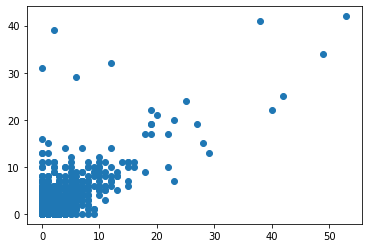

In [23]:
# check the relationship between cool & funny
plt.scatter(train_df_full['cool'], train_df_full['funny'])

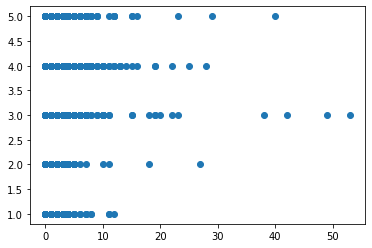

In [24]:
# check the relationship between useful and stars
plt.scatter(train_df_full['cool'], train_df_full['stars'])

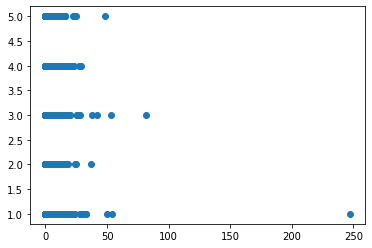

In [25]:
# check the relationship between useful and stars
plt.scatter(train_df_full['useful'], train_df_full['stars'])

(array([2534., 1354., 1888., 2110., 2114.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <BarContainer object of 5 artists>)

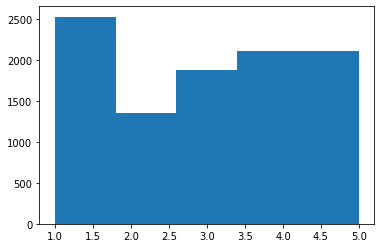

In [26]:
plt.hist(train_df_full['stars'], bins=5)

Moreover, you may use the id feature to aggregate data samples

For example

                 business_id  funny  cool  stars
7043  -0qht1roIqleKiQkBLDkbw      1     0      3
7363  -0qht1roIqleKiQkBLDkbw      0     0      5


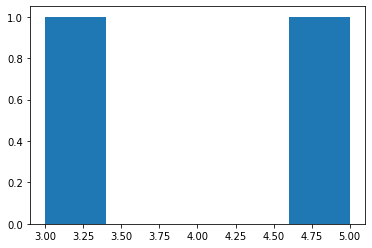

In [27]:
for bid, sub_df in train_df_full.groupby('business_id'):
    if len(sub_df) > 1:
        print(sub_df[['business_id', 'funny', 'cool', 'stars']].head())
        plt.hist(sub_df['stars'], bins=5)
        break

In [28]:
for bid, sub_df in train_df_full.groupby('user_id'):
    if len(sub_df) > 1:
        print(sub_df[['user_id', 'funny', 'cool', 'stars']].head())
        break

                     user_id  funny  cool  stars
1173  -SjQXQd-IRfOdUdYYwWGOQ      0     1      4
4503  -SjQXQd-IRfOdUdYYwWGOQ      0     0      1


## 3. Baselines

Finally, we come up with two baselines for you to refer.
We only use text data here and consider all training samples.

For example, a baseline can be a logistic regression

In [29]:
train_df = load_data('train')
valid_df = load_data('valid')

select [text, stars] columns from the train split
succeed!
select [text, stars] columns from the valid split
succeed!


The split above is what we have done for you. You can use the data as you like.

In [30]:
train_df

,text,stars
0,Nice to have a diner still around. Food was go...,4
1,"Tried this a while back, got the fried chicken...",2
2,I expected more pork selections on menu. Food ...,4
3,YUMMY!!! This place is phenomenal. It is Price...,4
4,The Truffle Macaroni & Cheese and Potatoes Au ...,5
...,...,...
9995,I think most people like this place because of...,2
9996,Thought I'd give this location a try from the ...,1
9997,"I first tried this place a while ago, and ever...",4
9998,Yummy yummy yummy I got the chicken fried stea...,5


In [31]:
train_df_full

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,39rLHYJOy2774ZIUouuWLw,0,2017-06-28 21:44:02,0,ynzOFepQYSCDGdfWDWxiZw,4,Nice to have a diner still around. Food was go...,0,Sl6VgFOB-XXfFIAYp7TFkw
1,E-Kq1Yu1d6N3TL2qX0aqjA,0,2018-04-09 03:45:19,0,sQX9ncJBEdBf16AWsvO6Vg,2,"Tried this a while back, got the fried chicken...",0,gcx01pMqWzkni2UC-zoZrA
2,nWW6fBfBljiRFa4sG7TyxA,0,2014-07-19 02:00:04,0,bVIf2kqbzvif3miNe3ARNw,4,I expected more pork selections on menu. Food ...,0,Mn9VzPbrCYU4EcP_C1oBOg
3,qmIHO-6T_KEfPC9jyGDamQ,0,2011-11-11 08:10:24,0,LNj1OFxy2ool3PZANGchPA,4,YUMMY!!! This place is phenomenal. It is Price...,0,SKV1heo00fdciCbCN9Z33A
4,pKk7jCFIm96qDdk0laVT2w,1,2010-01-16 20:04:00,1,bZXxa0hO6wQlHD-MkMf4iw,5,The Truffle Macaroni & Cheese and Potatoes Au ...,1,p1r7rZYruZR92x1A649PTQ
...,...,...,...,...,...,...,...,...,...
9995,i60v66vwf1A13YqcIqGD_A,0,2011-08-19 21:35:20,0,eTRXN4fJ-ss3Nb3tROVzMw,2,I think most people like this place because of...,0,eAQq7dUH0H9q1aAQ0pqJoA
9996,lXYTzkRVMHPYGcDRc_8JvQ,1,2015-03-28 05:33:06,1,uQ1v2LDSBz8W-spsEPRjug,1,Thought I'd give this location a try from the ...,1,F78tJHr0qW6FsYBtWMmLpA
9997,leMIHa6TogufHv5HNYjnfw,0,2015-03-14 23:20:51,0,prAKvb7E1FWNRdEGWEmIHg,4,"I first tried this place a while ago, and ever...",0,a2cxPk9PJkSxV5fFTUL5TA
9998,6Iu4YDjAPrDRRrPCt_E2zA,0,2017-01-31 20:33:36,0,Ncoi4AUV-hh_IaNTdtEzqQ,5,Yummy yummy yummy I got the chicken fried stea...,0,H-AafA7pWsVLoWP-rw-F_Q


In [32]:
test_df_full

,business_id,cool,date,funny,review_id,text,useful,user_id
0,7YYrZ9LgjpKLTtF-huhJug,0,2018-04-04 21:21:45,0,b8-ELBwhmDKcmcM8icT86g,I took the UP Train to Union Station to catch ...,0,9Lglv-v8SRo_S-IyvFBmbw
1,gyNixTgp1yFX97soBZpZ7Q,1,2013-07-10 00:04:01,0,rBpAJhIen_V-zLoXZIcROg,We worked with Fitness with a Twist for part o...,1,zIl62G84XT2BwSIAjjjvYw
2,vNWfQrQCa_XijstJbylcDQ,1,2015-10-28 01:23:21,2,_pALaDG6se9OTkGGhyhnNA,"It's your typical, average, run-of-the-mill co...",1,WP7FsUsgNW24s7HH5xi7pg
3,wfxmuA7LbKZKVLV58EiWBw,0,2015-11-19 03:48:40,0,ru8fpA1Uk0tTFtO5hLM49g,We went to Outback today to celebrate my daugh...,0,yLSj54f2YgGQu-lhPIhMTQ
4,5jTmjxb1X34EfcY1gos4tw,0,2016-06-04 23:29:46,0,fRPgwuFoY6SriToXZyaOQA,We Went to see Nashville unplugged a country c...,1,73-u0a3G9Le4GWG7zLYWtg
...,...,...,...,...,...,...,...,...
1995,rKl9yHz4LmQzD70yXBaRlg,0,2016-04-24 02:43:01,0,oZxqo6rspUimmoqKl0_qdA,This was an ok Burger joint. This chain is big...,1,XxG5SZOPkihWeJe3r9XL8Q
1996,Hqs4YNST_ZHbshwyi4bnsQ,3,2017-12-30 08:01:06,1,C_oCpNq91uTtOYUs2cChdg,Came here on a whim as we were passing through...,3,acPFDB6xB5qtcwTCI2wLvg
1997,46hnat0aLao-qYWZkN9aBg,1,2010-03-28 15:40:22,1,qMrxDB5fm8wIzexUp643xQ,This is my favorite Mexican food place on the ...,1,TJoILHOxI_K5kJUye0BtbA
1998,BGGQOJQTQerEQu0kHbT_UQ,0,2016-05-02 22:24:13,0,HrejfPp6Xduy5Pv7i-is1A,Stopped in here on 3/24/16 around 8pm when the...,0,PTHCHcBhJbyNS3hMSQ2pYQ


In [34]:
x_train_text = train_df_full['text']
x_train_useful = train_df_full['useful']
x_valid_text = valid_df['text']
# x_test_useful = valid_df['useful']

y_train = train_df['stars']
y_valid = valid_df['stars']

In [35]:
x_train_text

0       Nice to have a diner still around. Food was go...
1       Tried this a while back, got the fried chicken...
2       I expected more pork selections on menu. Food ...
3       YUMMY!!! This place is phenomenal. It is Price...
4       The Truffle Macaroni & Cheese and Potatoes Au ...
                              ...                        
9995    I think most people like this place because of...
9996    Thought I'd give this location a try from the ...
9997    I first tried this place a while ago, and ever...
9998    Yummy yummy yummy I got the chicken fried stea...
9999    4 stars for the beer selection. 1 star for the...
Name: text, Length: 10000, dtype: object

In [36]:
# pre-processing the data for better feature selection

In [37]:

# # load data
# train_ids, train_texts, train_labels = load_data(train_file)
# test_ids, test_texts, _ = load_data(test_file)
# test_labels = load_labels(ans_file)

# extract features
train_tokens = [tokenize(text) for text in x_train_text]
valid_tokens = [tokenize(text) for text in x_valid_text]

train_stemmed = [stem(tokens) for tokens in train_tokens]
valid_stemmed = [stem(tokens) for tokens in valid_tokens]

train_stemmed = [filter_stopwords(tokens) for tokens in train_stemmed]
valid_stemmed = [filter_stopwords(tokens) for tokens in valid_stemmed]

train_2_gram = [n_gram(tokens, 2) for tokens in train_stemmed]
train_3_gram = [n_gram(tokens, 3) for tokens in train_stemmed]
valid_2_gram = [n_gram(tokens, 2) for tokens in valid_stemmed]
valid_3_gram = [n_gram(tokens, 3) for tokens in valid_stemmed]


In [38]:
from itertools import chain
from collections import Counter
import keras

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

In [71]:
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.layers.core import Dense, Dropout, Activation, Flatten
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.utils import np_utils


In [72]:
from keras.layers import Dense, Activation, Embedding, Dropout, BatchNormalization, Input, Add, Concatenate,\
    Bidirectional, SimpleRNN, LSTM, GRU

In [131]:
# len(train_feats_matrix[0])

In [40]:
# build the feature list
# Multinomial Logistic Regression with tokenize & stopwords & stemmed & min_freq=8

max_len = 50
train_feats = list()
for i in range(len(x_train_text)):
    train_feats.append(
#         train_stemmed[i] + train_2_gram[i] + train_3_gram[i])
        train_stemmed[i])
valid_feats = list()
for i in range(len(x_valid_text)):
    valid_feats.append(
#         valid_stemmed[i] + valid_2_gram[i] + valid_3_gram[i])
        valid_stemmed[i])

# build a mapping from features to indices
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=8)

# build the feats_matrix
# convert each example to a ont-hot vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_onehot_vector(f, feats_dict) for f in train_feats])
valid_feats_matrix = np.vstack(
    [get_onehot_vector(f, feats_dict) for f in valid_feats])

# convert labels to label_matrix
num_classes = max(y_train)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(y_train-1, num_classes=num_classes)
valid_label_matrix = keras.utils.to_categorical(y_valid-1, num_classes=num_classes)

Size of features: 5033


stemmed feature size: 24119


<ipython-input-41-c1708e8294f5>:24: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.loglog(range(1, len(stemmed_feat_cnt)+1),
<ipython-input-41-c1708e8294f5>:24: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.loglog(range(1, len(stemmed_feat_cnt)+1),


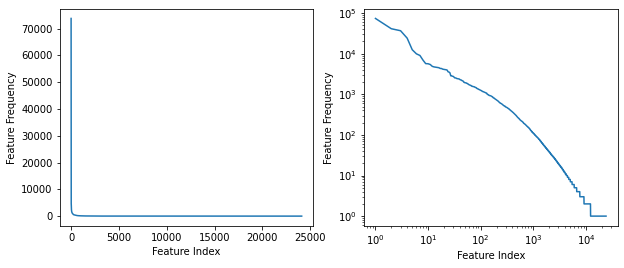

In [41]:
# first, build a Counter for stemmed features, e.g., {"text": 2, "mine": 1}
stemmed_feat_cnt = Counter()
for feats in train_stemmed:
    stemmed_feat_cnt.update(feats)
print("stemmed feature size:", len(stemmed_feat_cnt))

# then, get the sorted features by the frequency
stemmed_feat_keys = [f for f, cnt in stemmed_feat_cnt.most_common()]

# draw linear lines and log lines for sorted features
# set the figure size
plt.figure(figsize=(10,4))
# generate two subfigures and set current as the first one
plt.subplot(1,2,1)
# draw linear lines
plt.plot(range(1, len(stemmed_feat_cnt)+1),
         [stemmed_feat_cnt[f] for f in stemmed_feat_keys])
# set labels
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
# set current as the second one
plt.subplot(1,2,2)
# draw log lines
plt.loglog(range(1, len(stemmed_feat_cnt)+1),
           [stemmed_feat_cnt[f] for f in stemmed_feat_keys],
           basex=10, basey=10)
# set labels
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
plt.show()

<ipython-input-42-c5e144309663>:33: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.loglog(range(1, len(stemmed_feat_cnt)+1),
<ipython-input-42-c5e144309663>:33: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.loglog(range(1, len(stemmed_feat_cnt)+1),
<ipython-input-42-c5e144309663>:36: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.loglog(range(1, len(bi_gram_feat_cnt)+1),
<ipython-input-42-c5e144309663>:36: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases lat

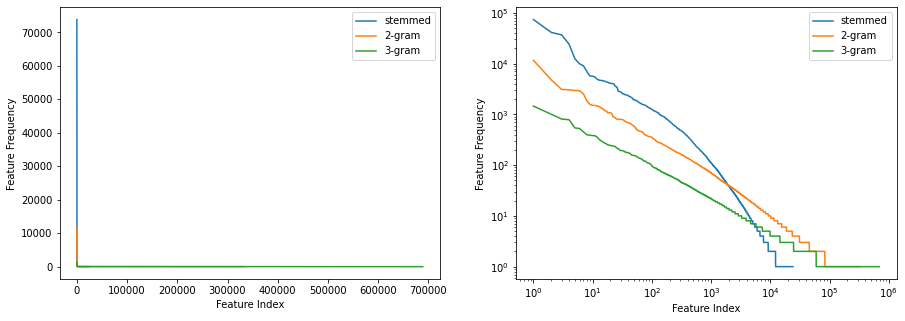

stemmed feature size: 24119
2-gram feature size: 331339
3-gram feature size: 688795


In [42]:
# build Counters for 2-gram features and 3-gram features
bi_gram_feat_cnt = Counter()
for feats in train_2_gram:
    bi_gram_feat_cnt.update(feats)
    
tri_gram_feat_cnt = Counter()
for feats in train_3_gram:
    tri_gram_feat_cnt.update(feats)

# then, get the sorted features by the frequency
bi_gram_feat_keys = [f for f, cnt in bi_gram_feat_cnt.most_common()]
tri_gram_feat_keys = [f for f,cnt in tri_gram_feat_cnt.most_common()]

# draw linear lines and log lines for sorted features
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
# put the four linear lines together
plt.plot(range(1, len(stemmed_feat_cnt)+1),
         [stemmed_feat_cnt[f] for f in stemmed_feat_keys],
         label="stemmed")
plt.plot(range(1, len(bi_gram_feat_cnt)+1),
         [bi_gram_feat_cnt[f] for f in bi_gram_feat_keys],
         label="2-gram")
plt.plot(range(1, len(tri_gram_feat_cnt)+1),
         [tri_gram_feat_cnt[f] for f in tri_gram_feat_keys],
         label="3-gram")
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
# show the legend
plt.legend()
plt.subplot(1,2,2)
# put the four log lines together
plt.loglog(range(1, len(stemmed_feat_cnt)+1),
         [stemmed_feat_cnt[f] for f in stemmed_feat_keys],
           basex=10, basey=10, label="stemmed")
plt.loglog(range(1, len(bi_gram_feat_cnt)+1),
         [bi_gram_feat_cnt[f] for f in bi_gram_feat_keys],
           basex=10, basey=10, label="2-gram")
plt.loglog(range(1, len(tri_gram_feat_cnt)+1),
         [tri_gram_feat_cnt[f] for f in tri_gram_feat_keys],
           basex=10, basey=10, label="3-gram")
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
# show the legend
plt.legend()
plt.show()

print("stemmed feature size:", len(stemmed_feat_cnt))
print("2-gram feature size:", len(bi_gram_feat_cnt))
print("3-gram feature size:", len(tri_gram_feat_cnt))

In [43]:
print("stemmed features > 10:",
      len([f for f, cnt in stemmed_feat_cnt.items() if cnt > 10]))
print("2-gram features > 10:",
      len([f for f, cnt in bi_gram_feat_cnt.items() if cnt > 10]))
print("3-gram features > 10:",
      len([f for f, cnt in tri_gram_feat_cnt.items() if cnt > 10]))

stemmed features > 10: 4217
2-gram features > 10: 9173
3-gram features > 10: 2870


In [44]:
print("stemmed features top 10:",
      stemmed_feat_keys[:10])
print("2-gram features top 10:",
      bi_gram_feat_keys[:10])
print("3-gram features top 10:",
      tri_gram_feat_keys[:10])

stemmed features top 10: ['.', ',', 'I', 'wa', '!', 'thi', "n't", "'s", 'food', 'place']
2-gram features top 10: ['. I', ', I', '! !', '. We', '. It', 'I wa', 'thi place', "I 'm", 'I would', "I n't"]
3-gram features top 10: ['! ! !', '. It wa', ". It 's", '. I wa', ". I 'm", '. I would', ". I n't", 'thi place .', ', I wa', ". I 've"]


In [127]:
# train_feats_matrix

In [128]:
# train_label_matrix

In [129]:
# y_train

In [130]:
# num_classes

In [49]:
len(feats_dict)

5033

In [50]:
# Model Selection

In [51]:
model_test = LogisticRegression(C=1.0, tol=1e-6, multi_class='multinomial', solver='newton-cg')
model_test.fit(train_feats_matrix, y_train)

LogisticRegression(multi_class='multinomial', solver='newton-cg', tol=1e-06)

In [52]:
#Multinomial Logistic Regression with tokenize & stopwords & stemmed & min_freq=8
y_valid = valid_df['stars']
y_pred = model_test.predict(valid_feats_matrix)
print(classification_report(y_valid, y_pred))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

              precision    recall  f1-score   support

           1       0.72      0.75      0.74       517
           2       0.35      0.26      0.30       278
           3       0.42      0.43      0.43       344
           4       0.45      0.49      0.47       427
           5       0.65      0.64      0.65       434

    accuracy                           0.55      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.54      0.55      0.55      2000




[[389  64  36  15  13]
 [ 94  73  72  30   9]
 [ 30  55 149  92  18]
 [ 17  12  79 210 109]
 [ 11   6  19 119 279]]
accuracy 0.55


In [74]:
# Try Word2Vec
# first save the reviews to txt
x_w2v_train = train_df['text']
x_w2v_train.to_csv('x_w2v_train.txt', header=True, index=False, sep='\t', mode='a')

In [75]:
def build_RNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size,
              num_rnn_layers, num_mlp_layers,
              rnn_type="lstm",
              bidirectional=False,
              embedding_matrix=None,
              activation="tanh",
              dropout_rate=0.0,
              batch_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="Adam",
              learning_rate=0.001,
              metric="accuracy"):
    """
    :param input_length: the maximum length of sentences, type: int
    :param vocab_size: the vacabulary size, type: int
    :param embedding_size: the dimension of word representations, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param output_size: the dimension of the prediction, type: int
    :param num_rnn_layers: the number of layers of the RNN, type: int
    :param num_mlp_layers: the number of layers of the MLP, type: int
    :param rnn_type: the type of RNN, type: str
    :param bidirectional: whether to use bidirectional rnn, type: bool
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a RNN for text classification,
    # activation document: https://keras.io/activations/
    # dropout document: https://keras.io/layers/core/#dropout
    # embedding document: https://keras.io/layers/embeddings/#embedding
    # recurrent layers document: https://keras.io/layers/recurrent
    # batch normalization document: https://keras.io/layers/normalization/
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    x = Input(shape=(input_length,))
    
    ################################
    ###### Word Representation #####
    ################################
    # word representation layer
    if embedding_matrix is not None:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                        trainable=False)(x)
    else:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(x)
    
    ################################
    ####### Recurrent Layers #######
    ################################
    # recurrent layers
    if rnn_type == "rnn":
        fn = SimpleRNN
    elif rnn_type == "lstm":
        fn = LSTM
    elif rnn_type == "gru":
        fn = GRU
    else:
        raise NotImplementedError
    h = emb
    for i in range(num_rnn_layers):
        is_last = (i == num_rnn_layers-1)
        if bidirectional:
            h = Bidirectional(fn(hidden_size,
                                 kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                                 recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                                 return_sequences=not is_last))(h)
        else:
            h = fn(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=not is_last)(h)
        h = Dropout(dropout_rate, seed=0)(h)
    
    ################################
    #### Fully Connected Layers ####
    ################################
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.he_normal(seed=0),
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)
    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

In [76]:
from gensim.models import Word2Vec, KeyedVectors

filepath = '/Users/cinder/Desktop/COMP4332_project_1/comp4332-project1-cnn-trial/x_w2v_train.txt'
savepath = '/Users/cinder/Desktop/COMP4332_project_1/comp4332-project1-cnn-trial/word2vec.model'

In [77]:
word_vectors = Word2Vec(corpus_file=filepath, vector_size=100, epochs=10, sg=1).wv
word_vectors.save(savepath)

In [78]:
embedding_matrix_ex = np.zeros((len(feats_dict), 100), dtype=np.float32)
wv = KeyedVectors.load(savepath, mmap='r')
print("number of words:", len(wv), "word dimension:", wv.vector_size)
for i in range(len(wv)):
    word = wv.index_to_key[i]
    word_idx = feats_dict.get(word, -1)
    if word_idx != -1:
        embedding_matrix_ex[word_idx] = wv[word]
print(embedding_matrix_ex[:5])

number of words: 29824 word dimension: 100
[[-0.5998442   0.6131503  -0.9660659  -0.07950827 -0.07484288 -0.3059396
   0.6332005   0.34530473 -0.37493116 -0.16765895  0.05021165 -0.10605764
  -0.07105534  0.13796109  0.45696557 -0.10299909  0.3098173  -0.11630185
  -0.30655727  0.10774532  0.17334558  0.6565228   0.22026393  0.83959264
   0.42989415  0.24455665 -0.49903774 -0.13635543 -0.33855587  0.6550114
   0.18658121 -0.6389449   0.01588     0.10817884  0.15469928  0.14937851
   0.17724782  0.13383289 -0.5833301  -0.5840255   0.26475614 -0.09420545
  -0.42661542  0.38296443  0.4595537  -0.33373064  0.30191153  0.07722851
   1.0045336   0.24421194  0.5316543  -0.27285835 -0.23970748  0.24268976
  -0.35453716 -0.22219856  0.06470132 -0.47747993 -0.1774784   0.5965443
   0.10574081 -0.66837907 -0.20171535 -0.6764929  -0.33531955  0.6731742
  -0.17177683  0.06044043  0.40564236 -0.10643754 -0.47370905 -0.4972027
   0.40795925 -0.4074656   0.24964446  0.472266   -0.07923251  0.35005948


In [79]:
# build the feature list
# W2V RNN

maximum_len = 50
train_w2v_feats = list()
for i in range(len(x_train_text)):
    train_w2v_feats.append(
#         train_stemmed[i] + train_2_gram[i] + train_3_gram[i])
        train_stemmed[i])
valid_w2v_feats = list()
for i in range(len(x_valid_text)):
    valid_w2v_feats.append(
#         valid_stemmed[i] + valid_2_gram[i] + valid_3_gram[i])
        valid_stemmed[i])

# build a mapping from features to indices
feats_w2v_dict = get_feats_dict(
    chain.from_iterable(train_w2v_feats),
    min_freq=8)

# build the feats_matrix
# convert each example to a ont-hot vector, and then stack vectors as a matrix
train_w2v_feats_matrix = np.vstack(
    [get_index_vector(f, feats_w2v_dict, maximum_len) for f in train_w2v_feats])
valid_w2v_feats_matrix = np.vstack(
    [get_index_vector(f, feats_w2v_dict, maximum_len) for f in valid_w2v_feats])

# convert labels to label_matrix
num_classes = max(y_train)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_w2v_label_matrix = keras.utils.to_categorical(y_train-1, num_classes=num_classes)
valid_w2v_label_matrix = keras.utils.to_categorical(y_valid-1, num_classes=num_classes)

Size of features: 5033


In [80]:
import os
import tensorflow as tf

In [81]:
# # Word2Vec RNN

# maximum_len = 100

# # build the feats_matrix
# # convert each example to a index vector, and then stack vectors as a matrix
# train_w2v_feats_matrix = np.vstack(
#     [get_index_vector(f, feats_w2v_dict, maximum_len) for f in train_w2v_feats])
# valid_w2v_feats_matrix = np.vstack(
#     [get_index_vector(f, feats_w2v_dict, maximum_len) for f in valid_w2v_feats])

# # convert labels to label_matrix
# num_classes = max(train_labels)
# # convert each label to a ont-hot vector, and then stack vectors as a matrix
# train_label_matrix = keras.utils.to_categorical(train_labels-1, num_classes=num_classes)
# test_label_matrix = keras.utils.to_categorical(test_labels-1, num_classes=num_classes)

In [83]:
# y_w2v = model.predict(valid_w2v_feats_matrix)

In [85]:
# y_w2v

In [ ]:
# valid_w2v_label_matrix

In [ ]:
# print(X_tfidf.shape)

In [86]:
# Demo Logistical + multinomial
# The result shows that multinomial is better!
x_demo_train = train_df['text']
y_demo_train = train_df['stars']

tfidf = TfidfVectorizer(tokenizer=tokenize)
lr = LogisticRegression(C=1.0, tol=1e-6, multi_class='multinomial', solver='newton-cg')
steps = [('tfidf', tfidf),('lr', lr)]
pipe_demo = Pipeline(steps)
print(pipe_demo)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f98418dec10>)),
                ('lr',
                 LogisticRegression(multi_class='multinomial',
                                    solver='newton-cg', tol=1e-06))])


In [87]:
pipe_demo.fit(x_demo_train, y_demo_train)

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f98418dec10>)),
                ('lr',
                 LogisticRegression(multi_class='multinomial',
                                    solver='newton-cg', tol=1e-06))])

In [88]:
x_demo_valid = valid_df['text']
y_demo_valid = valid_df['stars']
y_demo_pred = pipe_demo.predict(x_demo_valid)
print(classification_report(y_demo_valid, y_demo_pred))
print("\n\n")
print(confusion_matrix(y_demo_valid, y_demo_pred))
print('accuracy', np.mean(y_demo_valid == y_demo_pred))

              precision    recall  f1-score   support

           1       0.69      0.87      0.77       517
           2       0.44      0.21      0.28       278
           3       0.48      0.47      0.47       344
           4       0.51      0.54      0.53       427
           5       0.71      0.71      0.71       434

    accuracy                           0.60      2000
   macro avg       0.57      0.56      0.55      2000
weighted avg       0.59      0.60      0.59      2000




[[448  31  23   8   7]
 [111  58  78  22   9]
 [ 49  33 160  93   9]
 [ 16   8  69 231 103]
 [ 22   2   5  97 308]]
accuracy 0.6025


In [89]:
# Demo + hyperparameter training
# The result showing that without stop_words the performance is better!
x_demo_h_train = train_df['text']
y_demo_h_train = train_df['stars']

tfidf_h = TfidfVectorizer(tokenizer=tokenize, stop_words = 'english')
lr = LogisticRegression(C=1.0, tol=1e-6, multi_class='multinomial', solver='newton-cg')
steps_h = [('tfidf_h', tfidf_h),('lr', lr)]
pipe_demo_h = Pipeline(steps_h)
print(pipe_demo_h)


Pipeline(steps=[('tfidf_h',
                 TfidfVectorizer(stop_words='english',
                                 tokenizer=<function tokenize at 0x7f98418dec10>)),
                ('lr',
                 LogisticRegression(multi_class='multinomial',
                                    solver='newton-cg', tol=1e-06))])


In [90]:
pipe_demo_h.fit(x_demo_h_train, y_demo_h_train)

Pipeline(steps=[('tfidf_h',
                 TfidfVectorizer(stop_words='english',
                                 tokenizer=<function tokenize at 0x7f98418dec10>)),
                ('lr',
                 LogisticRegression(multi_class='multinomial',
                                    solver='newton-cg', tol=1e-06))])

In [91]:
x_demo_h_valid = valid_df['text']
y_demo_h_valid = valid_df['stars']
y_demo_h_pred = pipe_demo_h.predict(x_demo_h_valid)
print(classification_report(y_demo_h_valid, y_demo_h_pred))
print("\n\n")
print(confusion_matrix(y_demo_h_valid, y_demo_h_pred))
print('accuracy', np.mean(y_demo_h_valid == y_demo_h_pred))

              precision    recall  f1-score   support

           1       0.68      0.86      0.76       517
           2       0.44      0.22      0.30       278
           3       0.44      0.42      0.43       344
           4       0.51      0.52      0.51       427
           5       0.69      0.69      0.69       434

    accuracy                           0.59      2000
   macro avg       0.55      0.54      0.54      2000
weighted avg       0.57      0.59      0.57      2000




[[447  27  26   6  11]
 [113  62  71  26   6]
 [ 51  40 145  94  14]
 [ 21   9  69 222 106]
 [ 23   4  15  91 301]]
accuracy 0.5885


In [ ]:
# train_df

In [92]:
############ Try Bert

import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [93]:
train_bert_df = train_df
valid_bert_df = valid_df

In [94]:
for i in range(len(train_bert_df)):
    train_bert_df['stars'][i] = train_bert_df['stars'][i] -1

<ipython-input-94-6fe6d99a1b29>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_bert_df['stars'][i] = train_bert_df['stars'][i] -1


In [95]:
for i in range(len(valid_bert_df)):
    valid_bert_df['stars'][i] = valid_bert_df['stars'][i] -1

<ipython-input-95-ba037fa114d2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_bert_df['stars'][i] = valid_bert_df['stars'][i] -1


In [96]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    train_bert_df['text'], 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    valid_bert_df['text'], 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_bert_df['stars'])

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(valid_bert_df['stars'])

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/anaconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2068: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [97]:
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=num_classes,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [98]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 10

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [104]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(bert_model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 2

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [100]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [101]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# inputs

In [105]:

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    bert_model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = bert_model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    bert_model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        bert_model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = bert_model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(bert_model.state_dict(), f'/Users/cinder/Desktop/COMP4332_project_1/comp4332-project1-cnn-trial/bert_data/finetuned_BERT_epoch_{epoch}.bert_model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')



Epoch 1
Training loss: 0.6523314317092299
Validation loss: 0.9459494668990374
F1 Score (Weighted): 0.6412609544583778



Epoch 2
Training loss: 0.6035119053050876
Validation loss: 0.8905712267011404
F1 Score (Weighted): 0.6555688872746077



In [106]:
predictions

array([[-2.151398  , -0.6341162 ,  2.785958  ,  1.5555502 , -1.4009871 ],
       [-0.2130135 ,  2.7958763 ,  2.1233704 , -1.2353896 , -2.7109315 ],
       [ 2.4293492 ,  2.5757358 , -0.14212401, -2.541742  , -2.9131825 ],
       ...,
       [-1.578146  , -2.121511  , -1.2985153 ,  0.86633474,  3.8319721 ],
       [-2.1850622 ,  0.4447548 ,  3.6501243 ,  0.5884896 , -1.7608833 ],
       [-3.0847476 , -2.2397404 ,  0.557518  ,  3.7279282 ,  1.0521642 ]],
      dtype=float32)

In [107]:
true_vals

array([4, 2, 1, ..., 4, 2, 3])

In [115]:
list_pre = predictions.tolist()
pre_vals = []

for i in range(len(list_pre)):
    pre_vals.append(list_pre[i].index(max(list_pre[i])))


In [118]:
true_list = true_vals.tolist()

In [122]:
k = 0
for i in range(len(true_list)):
    if (pre_vals[i] == true_list[i]):
        k +=1

In [126]:
k/2000

0.66

In [ ]:
# logistR=LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [ ]:
# def build_classifier(input_size, output_size,
#                      loss="categorical_crossentropy",
#                      optimizer="SGD",
#                      learning_rate=0.1,
#                      metric="accuracy"):
#     """
#     :param input_size: the dimension of the input, type: int
#     :param output_size: the dimension of the prediction, type: int
#     :param l2_reg: the weight for the L2 regularizer, type: str
#     :param loss: the training loss, type: str
#     :param optimizer: the optimizer, type: str
#     :param learning_rate: the learning rate for the optimizer, type: float
#     :param metric: the metric, type: str
#     return a 1-layer perceptron,
#     # losses document: https://keras.io/losses/
#     # optimizers document: https://keras.io/optimizers/
#     # metrics document: https://keras.io/metrics/
#     """
# #     model = LogisticRegression(multi_class = 'multinomial')
#     model = Sequential()
# #     logistR=LogisticRegression(multi_class='multinomial', solver='newton-cg')
#     model.add(logistR)
# #     # the projection layer
# #     model.add(Dense(output_size,
# #                     activation="softmax",
# #                     input_dim=input_size,
# #                     bias_initializer="zeros"))
    
# #     # set the loss, the optimizer, and the metric
# #     if optimizer == "SGD":
# #         optimizer = keras.optimizers.SGD(lr=learning_rate)
# #     elif optimizer == "RMSprop":
# #         optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
# #     elif optimizer == "Adam":
# #         optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
# #     elif optimizer == "Adadelta'":
# #         optmizer = keras.optimizers.Adadelta(learning_rate=learning_rate)
# #     elif optimizer == "Adagrad":
# #         optmizer = keras.optimizers.Adagrad(learning_rate=learning_rate)
# #     elif optimizer == "Adamax":
# #         optmizer = keras.optimizers.Adamax(learning_rate=learning_rate)
# #     elif optimizer == "Nadam":
# #         optmizer = keras.optimizers.Nadam(learning_rate=learning_rate)
# #     else:
# #         raise NotImplementedError
# #     model.compile(loss=loss, optimizer=optimizer, metrics=[metric])

#     return model

In [ ]:
######## TRY RNN Model

In [ ]:
# y_train

In [ ]:
# x_valid = valid_df['text']
# y_valid = valid_df['stars']
# y_pred = pipe.predict(x_valid)
# print(classification_report(y_valid, y_pred))
# print("\n\n")
# print(confusion_matrix(y_valid, y_pred))
# print('accuracy', np.mean(y_valid == y_pred))

Of course, you can use deep learning.
Here is a pytorch based baseline using CNN

```bash
pip install torch
```

In [ ]:
# import torch
# from torch import nn
# from torch.utils.data import DataLoader, Dataset
# import tqdm

In [ ]:
# train_text = train_df['text'].map(tokenize).map(filter_stopwords).map(stem)
# valid_text = valid_df['text'].map(tokenize).map(filter_stopwords).map(stem)

In [ ]:
# word2id = {}
# for tokens in train_text:
#     for t in tokens:
#         if not t in word2id:
#             word2id[t] = len(word2id)
# word2id['<pad>'] = len(word2id)

In [ ]:
# def texts_to_id_seq(texts, padding_length=500):
#     records = []
#     for tokens in texts:
#         record = []
#         for t in tokens:
#             record.append(word2id.get(t, len(word2id)))
#         if len(record) >= padding_length:
#             records.append(record[:padding_length])
#         else:
#             records.append(record + [word2id['<pad>']] * (padding_length - len(record)))
#     return records

In [ ]:
# train_seqs = texts_to_id_seq(train_text)

In [ ]:
# valid_seqs = texts_to_id_seq(valid_text)

In [ ]:
# class MyDataset(Dataset):
    
#     def __init__(self, seq, y):
#         assert len(seq) == len(y)
#         self.seq = seq
#         self.y = y-1
    
#     def __getitem__(self, idx):
#         return np.asarray(self.seq[idx]), self.y[idx]

#     def __len__(self):
#         return len(self.seq)

In [ ]:
# batch_size = 16

# train_loader = DataLoader(MyDataset(train_seqs, y_train), batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(MyDataset(valid_seqs, y_valid), batch_size=batch_size)

In [ ]:
# class mlp(nn.Module):
#     def __init__(self):
#         super(mlp, self).__init__()
#         self.embedding = nn.Embedding(num_embeddings=len(word2id)+1, embedding_dim=64)
#         self.cnn = nn.Sequential(
#             nn.Conv1d(in_channels=64,
#                       out_channels=64,
#                       kernel_size=3,
#                       stride=1),
#             nn.MaxPool1d(kernel_size=3, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=64,
#                       out_channels=64,
#                       kernel_size=3,
#                       stride=1),
#             nn.MaxPool1d(kernel_size=3, stride=1),
#             nn.Dropout(0.5)
#         )
#         self.linear = nn.Linear(64, 5)
    
#     def forward(self, x):
#         x = self.embedding(x)
#         x = torch.transpose(x, 1, 2)
#         x = self.cnn(x)
#         x = torch.max(x, dim=-1)[0]
#         x = self.linear(x)
#         return x

In [ ]:
# model = mlp()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# criterion = torch.nn.CrossEntropyLoss()

In [ ]:
# for e in range(1, 11):    
#     print('epoch', e)
#     model.train()
#     total_acc = 0
#     total_loss = 0
#     total_count = 0
#     with tqdm.tqdm(train_loader) as t:
#         for x, y in t:
#             optimizer.zero_grad()
#             logits = model(x)
#             loss = criterion(logits, y)
#             loss.backward()
#             total_acc += (logits.argmax(1) == y).sum().item()
#             total_count += y.size(0)
#             total_loss += loss.item()
#             optimizer.step()
#             t.set_postfix({'loss': total_loss/total_count, 'acc': total_acc/total_count})

#     model.eval()
#     y_pred = []
#     y_true = []
#     with tqdm.tqdm(valid_loader) as t:
#         for x, y in t:
#             logits = model(x)
#             total_acc += (logits.argmax(1) == y).sum().item()
#             total_count += len(y)
#             y_pred += logits.argmax(1).tolist()
#             y_true += y.tolist()
#     print(classification_report(y_true, y_pred))
#     print("\n\n")
#     print(confusion_matrix(y_true, y_pred))

Deep learning are full of tricks. 

In the second example above, the implementation of CNN is not good enough to beat even TFIDF+Logistic regression.

You can use all the techniques introduced in the lectures and tutorials to enhance your methods.

Of course, you can use ideas have not been mentioned to make your model distinguished.